In [35]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [36]:
!pip install lib/kaggle-rig-0.2.0.tar.gz
import krig
krig.seed_everything()

Processing ./lib/kaggle-rig-0.2.0.tar.gz
  Created wheel for kaggle-rig: filename=kaggle_rig-0.2.0-py3-none-any.whl size=6539 sha256=5c0f9b2456466db91aeb6a3c0e71223aba0ee5efaf5e93c4c62d2b5dfa42a349
  Stored in directory: /home/pankun/.cache/pip/wheels/03/99/72/07676e0abd65551d5261aee9360ad1c85fcaca1c409857a40a
Successfully built kaggle-rig
  Attempting uninstall: kaggle-rig
    Found existing installation: kaggle-rig 0.2.0
    Uninstalling kaggle-rig-0.2.0:
      Successfully uninstalled kaggle-rig-0.2.0


In [37]:
FOLDS = 10
DATA = 'input/processed'
TARGET = ['fvc_last_3', 'fvc_last_2', 'fvc_last_1']
NON_FEATURES = set(TARGET) | {'pid', 'week_last_1', 'week_last_2', 'week_last_3'}
CATEGORICALS = {'sex', 'smoking'}
SCORING = 'neg_root_mean_squared_error'

In [38]:
# Characters such as empty strings '' or numpy.inf are considered NA values
pd.set_option('use_inf_as_na', True)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
sns.set(style="whitegrid")

In [39]:
train = pd.read_parquet(f'{DATA}/cvtrain.parquet')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pid                    174 non-null    object 
 1   age                    174 non-null    uint8  
 2   sex                    174 non-null    object 
 3   smoking                174 non-null    object 
 4   week_1                 174 non-null    int16  
 5   fvc_1                  174 non-null    uint16 
 6   percent_1              174 non-null    float32
 7   fvc_last_1             174 non-null    uint16 
 8   fvc_last_2             174 non-null    uint16 
 9   fvc_last_3             174 non-null    uint16 
 10  week_last_1            174 non-null    int16  
 11  week_last_2            174 non-null    int16  
 12  week_last_3            174 non-null    int16  
 13  fvc_last_1_min         174 non-null    float32
 14  fvc_last_1_p50         174 non-null    float32
 15  fvc_la

In [40]:
train.head()

,pid,age,sex,smoking,week_1,fvc_1,percent_1,fvc_last_1,fvc_last_2,fvc_last_3,week_last_1,week_last_2,week_last_3,fvc_last_1_min,fvc_last_1_p50,fvc_last_1_p75,fvc_last_1_p90,fvc_last_1_p95,fvc_last_1_p99,fvc_last_1_max,fvc_last_2_min,fvc_last_2_p50,fvc_last_2_p75,fvc_last_2_p90,fvc_last_2_p95,fvc_last_2_p99,fvc_last_2_max,fvc_last_3_min,fvc_last_3_p50,fvc_last_3_p75,fvc_last_3_p90,fvc_last_3_p95,fvc_last_3_p99,fvc_last_3_max,lung_area_min,lung_area_p50,lung_area_p75,lung_area_p90,lung_area_p95,lung_area_p99,lung_area_max,tissue_area_min,tissue_area_p50,tissue_area_p75,tissue_area_p90,tissue_area_p95,tissue_area_p99,tissue_area_max,lung_tissue_ratio_min,lung_tissue_ratio_p50,lung_tissue_ratio_p75,lung_tissue_ratio_p90,lung_tissue_ratio_p95,lung_tissue_ratio_p99,lung_tissue_ratio_max
0,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,1978.999023,2163.414307,2245.636475,2302.243896,2325.134277,2361.633057,2375.124023,1972.674805,2158.872803,2241.027832,2296.689453,2321.185547,2356.164062,2368.978271,1971.525024,2157.224609,2239.290771,2294.936035,2319.231689,2354.291016,2367.138916,670.0,1656.0,2391.25,2693.100098,2721.350098,2828.399902,2869.0,4255.0,6106.0,9372.75,11325.299805,12560.299805,13245.419922,13333.0,0.059491,0.256664,0.446996,0.568525,0.573278,0.626535,0.647630
1,ID00009637202177434476278,69,Male,Ex-smoker,8,3660,85.282875,3214,3390,3625,60,45,33,2353.556885,2569.670898,2612.105713,2647.932373,2675.963867,2724.578613,2754.314941,2349.640869,2566.023438,2608.655762,2644.478516,2672.824951,2721.939209,2751.810547,2347.598389,2563.716797,2606.209473,2641.983643,2670.250244,2719.266846,2749.090332,704.0,2156.5,2867.00,3206.899902,3339.449951,3478.419922,3523.0,9535.0,11885.5,16274.00,18535.300781,19007.099609,19512.429688,19734.0,0.039308,0.198787,0.255620,0.288663,0.300436,0.322504,0.335254
2,ID00010637202177584971671,60,Male,Ex-smoker,0,3523,94.724670,2518,2474,2993,54,37,25,1916.937744,2137.227783,2218.732910,2280.805664,2323.173096,2400.881592,2453.674316,1913.829468,2133.096191,2214.933838,2276.977539,2319.736328,2398.224609,2451.613770,1912.415771,2131.439453,2213.152588,2275.168701,2317.730957,2396.070312,2449.310059,232.0,1288.5,2612.75,3364.000000,3721.250000,4241.149902,4315.0,6774.0,10859.0,12289.00,15495.000000,16202.750000,16849.349609,16897.0,0.013873,0.115833,0.317440,0.443931,0.488324,0.562757,0.585732
3,ID00012637202177665765362,65,Male,Never smoked,33,3418,93.726006,2971,3231,3324,87,71,58,2072.881348,2363.911377,2582.803223,2643.715332,2682.396973,2707.468750,2714.466064,2068.818848,2357.947754,2577.690918,2638.745605,2677.512451,2702.326904,2708.766113,2067.409668,2356.075684,2575.499268,2636.387451,2675.054688,2699.848633,2706.267578,204.0,1129.0,1826.00,2223.399902,2491.600098,2976.679932,3089.0,5799.0,7015.0,8992.00,10425.000000,10657.200195,11110.839844,11371.0,0.024120,0.147254,0.295255,0.343806,0.391733,0.479589,0.516469
4,ID00014637202177757139317,56,Male,Ex-smoker,0,3807,90.076660,3027,3439,3221,54,37,26,2185.426025,2524.706543,2609.033203,2657.202637,2705.106934,2763.291992,2769.243164,2180.678711,2520.838135,2604.246582,2652.411377,2701.143066,2759.472900,2766.047607,2179.241943,2518.798096,2601.931641,2650.074219,2698.735840,2756.972412,2763.516113,516.0,1537.0,2958.50,3736.000000,4082.000000,5042.600098,5360.0,7745.0,10419.0,13426.50,17834.000000,18872.000000,19514.500000,19651.0,0.028359,0.143710,0.316701,0.432157,0.452699,0.625855,0.692059


In [41]:
def encode(df, col, encoder) -> None:
    df[col] = df[col].map(encoder).fillna(0)
    assert not df[col].isna().any()

 
for col in CATEGORICALS:
    encoder = dict(train[col].value_counts(normalize=True))
    print(f'col={col}, encoder={encoder}')
    encode(train, col, encoder)

col=smoking, encoder={'Ex-smoker': 0.6666666666666666, 'Never smoked': 0.28160919540229884, 'Currently smokes': 0.05172413793103448}
col=sex, encoder={'Male': 0.7873563218390804, 'Female': 0.21264367816091953}


In [42]:
FEATURES = set(train.columns) - NON_FEATURES
FEATURES = list(FEATURES)
FEATURES.sort()
print(f'{len(FEATURES)} FEATURES={FEATURES}')

48 FEATURES=['age', 'fvc_1', 'fvc_last_1_max', 'fvc_last_1_min', 'fvc_last_1_p50', 'fvc_last_1_p75', 'fvc_last_1_p90', 'fvc_last_1_p95', 'fvc_last_1_p99', 'fvc_last_2_max', 'fvc_last_2_min', 'fvc_last_2_p50', 'fvc_last_2_p75', 'fvc_last_2_p90', 'fvc_last_2_p95', 'fvc_last_2_p99', 'fvc_last_3_max', 'fvc_last_3_min', 'fvc_last_3_p50', 'fvc_last_3_p75', 'fvc_last_3_p90', 'fvc_last_3_p95', 'fvc_last_3_p99', 'lung_area_max', 'lung_area_min', 'lung_area_p50', 'lung_area_p75', 'lung_area_p90', 'lung_area_p95', 'lung_area_p99', 'lung_tissue_ratio_max', 'lung_tissue_ratio_min', 'lung_tissue_ratio_p50', 'lung_tissue_ratio_p75', 'lung_tissue_ratio_p90', 'lung_tissue_ratio_p95', 'lung_tissue_ratio_p99', 'percent_1', 'sex', 'smoking', 'tissue_area_max', 'tissue_area_min', 'tissue_area_p50', 'tissue_area_p75', 'tissue_area_p90', 'tissue_area_p95', 'tissue_area_p99', 'week_1']


In [43]:
x_train = train[FEATURES]

In [44]:
%%time
models = []
results = []


for col in TARGET:
    y_train = train[col]
    model = lgb.LGBMRegressor(reg_alpha=1)
    pipe = Pipeline([('model', model)])
    param_grid = {
        'model__n_estimators': [1000, 2000],
        'model__learning_rate': [0.01, 0.001],
        'model__subsample': [1],
        'model__min_child_samples': [20],
        'model__colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
    lgbm = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
    lgbm.fit(x_train, y_train)
    best_score = lgbm.best_score_
    best_score_std = lgbm.cv_results_['std_test_score'][lgbm.best_index_]
    print(f"""LGBM y={col}
best params={repr(lgbm.best_params_)}
best score={best_score:0.3f}, std={best_score_std:0.3f}
    """)
    res = pd.DataFrame.from_dict(lgbm.cv_results_)
    res.set_index('rank_test_score', inplace=True)
    res.sort_index(inplace=True)
    models.append(lgbm)
    results.append(res)

LGBM y=fvc_last_3
best params={'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__n_estimators': 1000, 'model__subsample': 1}
best score=-315.591, std=74.497
    
LGBM y=fvc_last_2
best params={'model__colsample_bytree': 1, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__n_estimators': 1000, 'model__subsample': 1}
best score=-339.429, std=78.999
    
LGBM y=fvc_last_1
best params={'model__colsample_bytree': 0.6, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__n_estimators': 1000, 'model__subsample': 1}
best score=-354.219, std=75.451
    
CPU times: user 15min 53s, sys: 14.7 s, total: 16min 8s
Wall time: 2min 45s


In [45]:
results[0].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,,
1,0.186295,0.143741,0.002098,0.000386,0.8,0.01,20,1000,1,"{'model__colsample_bytree': 0.8, 'model__learn...",-336.394375,-307.513633,-313.851064,-256.793456,-361.834776,-490.011895,-253.096154,-211.500600,-358.387489,-266.526212,-315.590965,74.497415
2,0.145933,0.018206,0.002382,0.001363,0.7,0.01,20,1000,1,"{'model__colsample_bytree': 0.7, 'model__learn...",-336.019599,-306.783691,-314.448680,-263.489422,-363.905484,-491.984000,-250.333468,-213.916039,-369.941200,-267.068004,-317.788959,75.177133
3,0.151682,0.065218,0.002238,0.000487,0.9,0.01,20,1000,1,"{'model__colsample_bytree': 0.9, 'model__learn...",-330.585409,-301.215879,-318.808792,-269.943604,-370.844908,-491.812421,-255.115364,-222.214130,-354.532228,-266.992102,-318.206484,72.676617
4,0.486838,0.472906,0.003604,0.002656,0.8,0.01,20,2000,1,"{'model__colsample_bytree': 0.8, 'model__learn...",-339.407919,-300.399728,-303.723785,-275.943301,-359.265721,-488.910301,-262.733442,-218.513035,-362.086176,-280.018221,-319.100163,70.696525
5,0.312246,0.039017,0.002297,0.000510,0.9,0.001,20,2000,1,"{'model__colsample_bytree': 0.9, 'model__learn...",-321.398446,-303.997458,-375.827971,-256.971464,-327.049675,-549.870945,-282.079321,-188.424276,-343.042225,-245.819244,-319.448102,92.205519
6,0.140655,0.014584,0.002301,0.000846,0.6,0.01,20,1000,1,"{'model__colsample_bytree': 0.6, 'model__learn...",-333.502265,-308.307805,-313.442053,-272.627145,-373.545650,-492.285923,-254.250425,-219.196474,-366.778384,-266.661662,-320.059779,73.941400
7,0.269278,0.029919,0.002926,0.002684,1,0.001,20,2000,1,"{'model__colsample_bytree': 1, 'model__learnin...",-315.432054,-299.597029,-380.655656,-267.059082,-330.205748,-541.783078,-286.751185,-201.456743,-335.587590,-252.598056,-321.112622,87.259665
8,0.249514,0.006876,0.002130,0.000113,0.7,0.01,20,2000,1,"{'model__colsample_bytree': 0.7, 'model__learn...",-341.987081,-296.098533,-306.859394,-279.835117,-362.613592,-483.353464,-256.620379,-224.448913,-376.804910,-284.087485,-321.270887,69.991585
9,0.292324,0.027454,0.002164,0.000149,0.9,0.01,20,2000,1,"{'model__colsample_bytree': 0.9, 'model__learn...",-333.844790,-291.513655,-308.435018,-285.502552,-372.460883,-483.127508,-263.998707,-233.691969,-365.516779,-280.885510,-321.897737,67.705708


In [46]:
results[1].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,,
1,0.123630,0.004517,0.001883,0.000035,1,0.01,20,1000,1,"{'model__colsample_bytree': 1, 'model__learnin...",-387.300961,-360.436361,-281.984879,-265.618198,-383.974268,-536.079876,-315.541378,-257.147612,-315.193434,-291.014392,-339.429136,78.999320
2,0.129529,0.010132,0.002052,0.000258,0.9,0.01,20,1000,1,"{'model__colsample_bytree': 0.9, 'model__learn...",-395.381582,-368.102636,-291.462836,-253.572626,-382.458031,-544.639795,-313.911003,-246.327958,-320.616062,-292.244753,-340.871728,83.346472
3,0.119177,0.003191,0.001903,0.000099,0.7,0.01,20,1000,1,"{'model__colsample_bytree': 0.7, 'model__learn...",-393.646327,-368.387418,-285.781411,-262.750273,-379.360984,-549.867534,-324.340578,-236.175757,-320.468848,-298.527350,-341.930648,84.423623
4,0.123074,0.003414,0.001945,0.000096,0.8,0.01,20,1000,1,"{'model__colsample_bytree': 0.8, 'model__learn...",-394.703858,-372.832474,-293.610075,-259.464780,-380.456773,-551.924313,-321.175191,-239.801654,-317.359509,-294.885158,-342.621379,84.929619
5,0.279369,0.018321,0.002326,0.000610,1,0.001,20,2000,1,"{'model__colsample_bytree': 1, 'model__learnin...",-368.493990,-344.463814,-344.828651,-281.696195,-321.950098,-609.386729,-330.423970,-237.103567,-333.355479,-259.495604,-343.119810,97.085860
6,0.370748,0.177732,0.004934,0.008706,0.9,0.001,20,2000,1,"{'model__colsample_bytree': 0.9, 'model__learn...",-369.560737,-350.158306,-348.590473,-273.149172,-317.561855,-620.765317,-337.102279,-234.760694,-339.266082,-263.721020,-345.463593,100.725723
7,0.149239,0.072565,0.001976,0.000101,0.6,0.01,20,1000,1,"{'model__colsample_bytree': 0.6, 'model__learn...",-388.270797,-376.239564,-307.798967,-269.014211,-396.508217,-543.468863,-325.520214,-243.048919,-322.463112,-289.907385,-346.224025,81.455893
8,0.269721,0.012420,0.002107,0.000120,1,0.01,20,2000,1,"{'model__colsample_bytree': 1, 'model__learnin...",-382.000106,-368.174099,-282.795201,-278.494175,-384.116637,-538.370676,-330.395295,-260.865984,-326.867536,-322.700684,-347.478039,75.615678
9,0.114479,0.004435,0.002243,0.000888,0.5,0.01,20,1000,1,"{'model__colsample_bytree': 0.5, 'model__learn...",-385.536462,-375.936901,-311.317954,-274.404366,-400.590887,-539.795556,-324.152780,-248.306303,-319.636614,-299.504225,-347.918205,78.845711


In [47]:
results[2].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,,
1,0.118070,0.007379,0.001922,0.000080,0.6,0.01,20,1000,1,"{'model__colsample_bytree': 0.6, 'model__learn...",-352.016131,-404.416807,-350.092303,-301.372984,-429.751171,-519.597187,-270.219749,-252.276868,-327.144874,-335.300791,-354.218887,75.450935
2,0.119342,0.002166,0.001971,0.000110,0.7,0.01,20,1000,1,"{'model__colsample_bytree': 0.7, 'model__learn...",-364.686033,-391.802794,-349.100408,-289.872553,-436.460929,-528.894965,-271.679892,-259.203655,-328.324092,-335.370883,-355.539621,77.338975
3,0.112865,0.004747,0.001983,0.000254,0.5,0.01,20,1000,1,"{'model__colsample_bytree': 0.5, 'model__learn...",-346.793818,-401.654002,-355.371171,-305.036370,-438.622936,-516.766694,-270.232974,-244.334873,-329.940366,-350.775397,-355.952860,76.138473
4,0.120323,0.004294,0.001921,0.000087,0.8,0.01,20,1000,1,"{'model__colsample_bytree': 0.8, 'model__learn...",-369.462154,-390.885272,-348.736547,-282.859746,-437.500160,-533.350236,-267.946120,-265.490798,-337.769732,-336.665793,-357.066656,78.444902
5,0.115593,0.009282,0.001953,0.000110,0.4,0.01,20,1000,1,"{'model__colsample_bytree': 0.4, 'model__learn...",-335.705745,-416.038790,-355.687247,-310.917940,-444.908702,-520.276653,-266.136205,-237.835887,-339.132945,-355.838733,-358.247885,79.506498
6,0.119438,0.002401,0.001874,0.000046,0.9,0.01,20,1000,1,"{'model__colsample_bytree': 0.9, 'model__learn...",-380.401049,-398.267090,-347.222880,-294.046543,-435.830651,-519.685616,-264.093077,-278.325265,-340.832128,-332.042075,-359.074637,73.927573
7,0.243277,0.004033,0.002371,0.000852,0.6,0.01,20,2000,1,"{'model__colsample_bytree': 0.6, 'model__learn...",-358.378483,-404.151486,-348.234669,-312.738957,-429.592944,-507.431673,-277.339590,-267.994044,-347.079777,-343.842226,-359.678385,68.284771
8,0.249486,0.006079,0.002119,0.000097,0.7,0.01,20,2000,1,"{'model__colsample_bytree': 0.7, 'model__learn...",-367.189506,-388.829392,-352.279500,-300.859137,-434.049989,-519.924106,-278.901016,-270.778604,-344.357526,-341.598233,-359.876701,71.147631
9,0.250836,0.003150,0.002057,0.000045,0.8,0.01,20,2000,1,"{'model__colsample_bytree': 0.8, 'model__learn...",-370.409251,-386.824561,-350.392329,-292.578969,-432.581707,-526.531673,-270.558854,-277.963746,-356.737863,-344.054524,-360.863347,73.112124


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

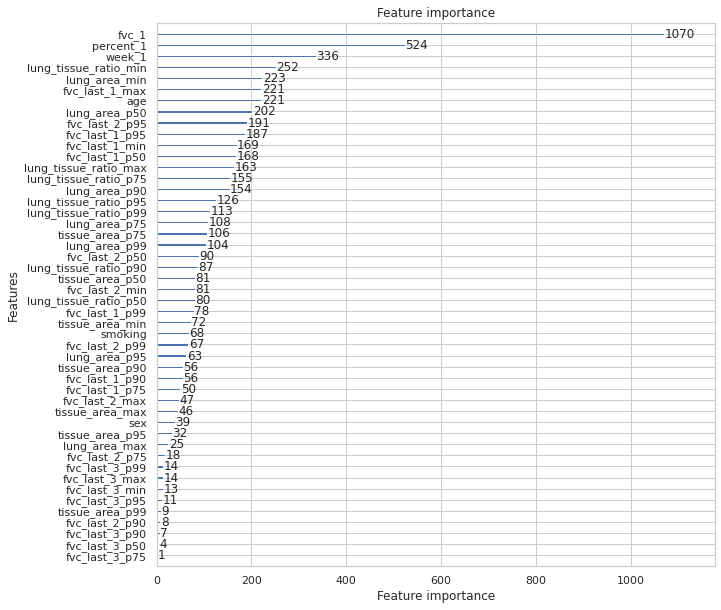

In [48]:
lgb.plot_importance(models[0].best_estimator_['model'], figsize=(10, 10))
    

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

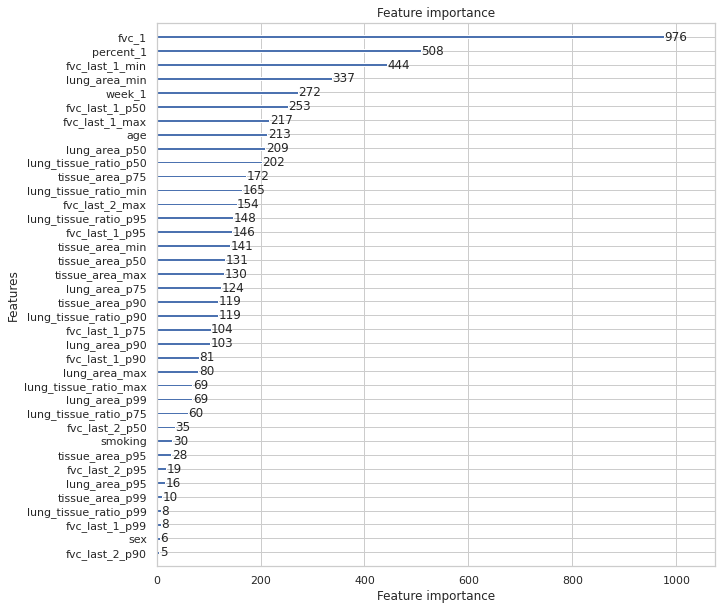

In [49]:
lgb.plot_importance(models[1].best_estimator_['model'], figsize=(10, 10))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

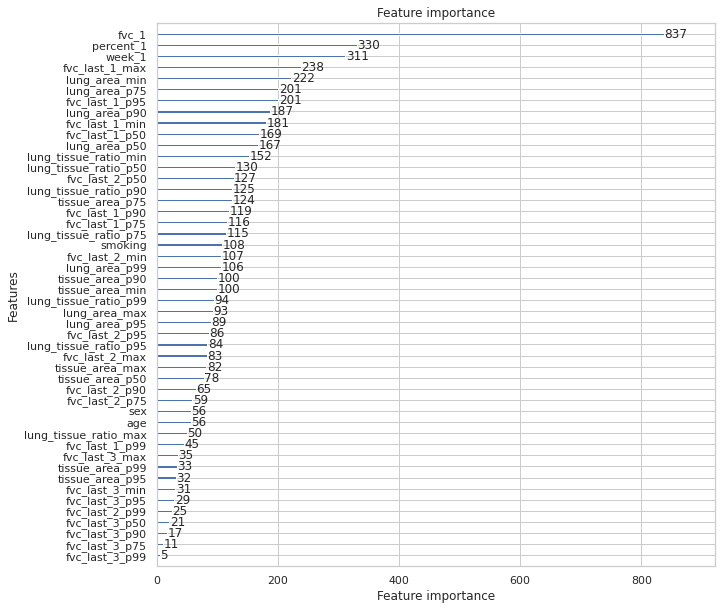

In [50]:
lgb.plot_importance(models[2].best_estimator_['model'], figsize=(10, 10))

In [51]:
for i in range(len(models)):
    y = TARGET[i]
    lgbm = models[i]
    lgbm.best_estimator_['model'].booster_.save_model(f'output/lgb_{y}.txt')